In [1]:
import os
import numpy as np
import cv2
import pandas as pd

# utils imports
import scipy.io as sio
import math
from math import cos, sin

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms
import torchvision
import torch.utils.model_zoo as model_zoo

import matplotlib.pyplot as plt

from PIL import Image, ImageFilter

# Utils

In [2]:
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    with open(file_path) as f:
        lines = f.read().splitlines()
    return lines

In [3]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    #print(f'this is the mat file fot sample {mat_path} : {mat}')
    pt2d = mat['pt2d']
    return pt2d

In [4]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [5]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [6]:
def plot_pose_cube(img, yaw, pitch, roll, tdx=None, tdy=None, size=150.):
    # Input is a cv2 image
    # pose_params: (pitch, yaw, roll, tdx, tdy)
    # Where (tdx, tdy) is the translation of the face.
    # For pose we have [pitch yaw roll tdx tdy tdz scale_factor]

    p = pitch * np.pi / 180
    y = -(yaw * np.pi / 180)
    r = roll * np.pi / 180
    if tdx != None and tdy != None:
        face_x = tdx - 0.50 * size
        face_y = tdy - 0.50 * size
    else:
        height, width = img.shape[:2]
        face_x = width / 2 - 0.5 * size
        face_y = height / 2 - 0.5 * size

    x1 = size * (cos(y) * cos(r)) + face_x
    y1 = size * (cos(p) * sin(r) + cos(r) * sin(p) * sin(y)) + face_y
    x2 = size * (-cos(y) * sin(r)) + face_x
    y2 = size * (cos(p) * cos(r) - sin(p) * sin(y) * sin(r)) + face_y
    x3 = size * (sin(y)) + face_x
    y3 = size * (-cos(y) * sin(p)) + face_y

    # Draw base in red
    cv2.line(img, (int(face_x), int(face_y)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(face_x), int(face_y)), (int(x2),int(y2)),(0,0,255),3)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x1-face_x),int(y2+y1-face_y)),(0,0,255),3)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x2-face_x),int(y1+y2-face_y)),(0,0,255),3)
    # Draw pillars in blue
    cv2.line(img, (int(face_x), int(face_y)), (int(x3),int(y3)),(255,0,0),2)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x3-face_x),int(y1+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x3-face_x),int(y2+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2+x1-face_x),int(y2+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(255,0,0),2)
    # Draw top in green
    cv2.line(img, (int(x3+x1-face_x),int(y3+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x2+x3-face_x),int(y2+y3-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x1-face_x),int(y3+y1-face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x2-face_x),int(y3+y2-face_y)),(0,255,0),2)

    return img

In [7]:
# ceate filesname file for dataset calss
def filter_samples(mat_path):
    '''
    neglect the samples with angel outside the angles range [-99, 99]
    paramters
    ---------
    mat_path : str, path for sample mat file that contains angel informations
    '''
    pose = get_ypr_from_mat(mat_path)
    pitch = pose[0] * 180 / np.pi
    yaw = pose[1] * 180 / np.pi
    roll = pose[2] * 180 / np.pi

    valid = (np.abs(pitch) > 99 or
           np.abs(yaw) > 99 or
           np.abs(roll) > 99)

    return valid

def find_filenams(imgs_folders, imgs_subfolders, filename_path):
    '''
    create file with the names of the training samples for 300W_LP dataset
    '''
    with open(f'{filename_path}/filename_list.txt', 'w') as names_file:
        valid_samples = 0
        for folder in imgs_subfolders:
            print(f'processing folder {folder}')
            for img_name in os.listdir(f'{imgs_folders}/{folder}') :
                # not image
                if not img_name.endswith('.jpg'): continue 
                file_name = f'{imgs_folders}/{folder}/{img_name.replace(".jpg","")}'
                # check tha angle range 
                if filter_samples(f'{file_name}.mat'): continue
                # save the sample
                names_file.write(f'{folder}/{img_name.replace(".jpg","")}\n')
                valid_samples += 1
                
        print(f'number of valid samples is {valid_samples}')

In [8]:
'''# creat the filenmae for 300W_LP Dataset without flipping dataset
SUBFOLDERS = ['AFW', 'HELEN', 'LFPW', 'IBUG']
imgs_folders = 'dataset/300W_LP'
filename_path = imgs_folders
find_filenams(imgs_folders, SUBFOLDERS, filename_path)'''

"# creat the filenmae for 300W_LP Dataset without flipping dataset\nSUBFOLDERS = ['AFW', 'HELEN', 'LFPW', 'IBUG']\nimgs_folders = 'dataset/300W_LP'\nfilename_path = imgs_folders\nfind_filenams(imgs_folders, SUBFOLDERS, filename_path)"

In [9]:
def write_to_file(file_path, data_list):
    with open(file_path,'w') as file:
        for item in data_list:
            file.write(item + '\n')

# split dataset
def split_dataset(filenames_list_path, training_pres = .9):
    # get file names
    filenames = get_list_from_filenames(filenames_list_path + '/filename_list.txt')
    # ranbomly shuffel dataset
    np.random.shuffle(filenames)
    num_training = int(len(filenames) * training_pres)
    print(f'number of training samples is {num_training}')
    train_dataset = filenames[:num_training]
    val_dataset = filenames[:num_training]
    # save splits
    write_to_file(filenames_list_path + '/filename_list_train.txt', train_dataset)
    write_to_file(filenames_list_path + '/filename_list_val.txt', val_dataset)    

In [10]:
'''split_dataset('dataset/300W_LP', training_pres = .9)'''

"split_dataset('dataset/300W_LP', training_pres = .9)"

# DataSet

In [11]:
class Pose_300W_LP(Dataset):
    # Head pose from 300W-LP dataset
    def __init__(self, data_dir, filename_path, transform, augment=True, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.transform = transform
        self.augment = augment
        self.img_ext = img_ext
        self.annot_ext = annot_ext
        # get the images subfolder/name
        filename_list = get_list_from_filenames(filename_path)

        self.X_train = filename_list
        self.y_train = filename_list
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        # load image
        img = Image.open(f'{self.data_dir}/{self.X_train[index]}{self.img_ext}')
        img = img.convert(self.image_mode)
        # load lables
        mat_path = f'{self.data_dir}/{self.y_train[index]}{self.annot_ext}'

        # Crop the face loosely
        # get the image 2D facila points
        pt2d = get_pt2d_from_mat(mat_path)
        # find the face BBOX form facila points
        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])
        
        # adjust the face BBOX to more sutable size
        
        # k = 0.2 to 0.40 I the BBOX scaling factor
        # increase the size of the BBOX for, .12 * 2, .24 * 2
        # but the size for y_min is scaled more as the min point in 2D is eyes
        # fix k size during evaluation
        if self.augment: k = np.random.random_sample() * 0.2 + 0.2
        else : k = .3
        x_min -= 0.6 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min) 
        x_max += 0.6 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi

        # Flip Augmentaion
        rnd = np.random.random_sample()
        if rnd < 0.5 and self.augment:
            yaw = -yaw
            roll = -roll
            img = img.transpose(Image.FLIP_LEFT_RIGHT)

        # Blur Augmentaion
        rnd = np.random.random_sample()
        if rnd < 0.05 and self.augment:
            img = img.filter(ImageFilter.BLUR)

        # Bin values
        bins = np.array(range(-99, 102, 3)) # [-99, 99]
        # output: array(1*3) value[0, 66[, the number of the region each angle in
        binned_pose = np.digitize([yaw, pitch, roll], bins) - 1

        # Get target tensors
        labels = binned_pose
        angles = torch.FloatTensor([yaw, pitch, roll])

        if self.transform is not None:
            img = self.transform(img)
        else :
            img = transforms.ToTensor()(img)

        return img, labels, angles, self.X_train[index]

    def __len__(self):
        # 61,225 without flipping data
        return self.length

(240, 240, 3) <class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


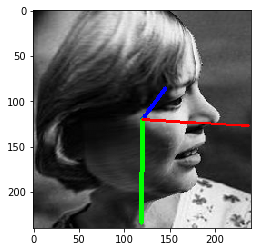

In [12]:
# test dataset
dataset = Pose_300W_LP(data_dir = '../dataset/300W_LP', filename_path = '../dataset/300W_LP/filename_list.txt', transform = None)
dl = DataLoader(dataset, batch_size=1, shuffle=True)

for img, dig_labels, exact_labels, img_path in dl:
    img, dig_labels, exact_labels, img_path = img[0], dig_labels[0], exact_labels[0], img_path[0]
    # draw the head pose estimation axes
    image = img.permute((1,2,0)).numpy()
    image = cv2.resize(image, dsize=(240, 240), interpolation=cv2.INTER_CUBIC)
    #image = cv2.imread(os.path.join('dataset/300W_LP', img_path + '.jpg'))
    print(image.shape, type(image))
    draw_axis(image, exact_labels[0], exact_labels[1], exact_labels[2], 
              tdx = image.shape[1] / 2, tdy= (image.shape[0]) / 2, size = image.shape[0]/2)
    plt.imshow(image)
    break

# Arch

In [13]:
class Hopenet(nn.Module):
    # Hopenet with 3 output layers for yaw, pitch and roll
    # Predicts Euler angles by binning and regression with the expected value
    def __init__(self, block, layers, num_bins):
        self.inplanes = 64
        super(Hopenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc_yaw = nn.Linear(512 * block.expansion, num_bins)
        self.fc_pitch = nn.Linear(512 * block.expansion, num_bins)
        self.fc_roll = nn.Linear(512 * block.expansion, num_bins)

        # Vestigial layer from previous experiments
        self.fc_finetune = nn.Linear(512 * block.expansion + 3, 3)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        pre_yaw = self.fc_yaw(x)
        pre_pitch = self.fc_pitch(x)
        pre_roll = self.fc_roll(x)

        return pre_yaw, pre_pitch, pre_roll

# Train

## Logger

In [50]:
import tensorflow as tf


class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def add_scalar(self, tag, value, global_step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, global_step)

In [51]:
# create logger file
logger = Logger('log_dir')

## variables 

In [17]:
num_epochs = 25
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoints_file = 'checkpoints'
last_checkpoint = f'{checkpoints_file}/headpose_last.pth'
best_checkpoint = f'{checkpoints_file}/headpose_best.pth'
best_checkpoint_acc = f'{checkpoints_file}/headpose_best_acc.pth'
# create checkpoints file
os.makedirs(checkpoints_file, exist_ok=True)
# dataset variables
data_dir = '../dataset/300W_LP'
filename_list_train = f'{data_dir}/filename_list_train.txt'
filename_list_val = f'{data_dir}/filename_list_val.txt'

lr = 0.00001

best_loss = 1e6
best_acc = 0

alpha = 1

In [18]:
device

'cuda'

## Helper Functions

In [19]:
def get_ignored_params(model):
    # Generator function that yields ignored params.
    b = [model.conv1, model.bn1, model.fc_finetune]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            if 'bn' in module_name:
                module.eval()
            for name, param in module.named_parameters():
                yield param

def get_non_ignored_params(model):
    # Generator function that yields params that will be optimized.
    b = [model.layer1, model.layer2, model.layer3, model.layer4]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            if 'bn' in module_name:
                module.eval()
            for name, param in module.named_parameters():
                yield param

def get_fc_params(model):
    # Generator function that yields fc layer params.
    b = [model.fc_yaw, model.fc_pitch, model.fc_roll]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            for name, param in module.named_parameters():
                yield param

def load_filtered_state_dict(model, snapshot):
    # By user apaszke from discuss.pytorch.org
    model_dict = model.state_dict()
    snapshot = {k: v for k, v in snapshot.items() if k in model_dict}
    model_dict.update(snapshot)
    model.load_state_dict(model_dict)

In [20]:
# intialize model
# ResNet50 structure
model = Hopenet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 66)
model.to(device)
softmax = nn.Softmax().to(device)

In [21]:
# load checkpoint
if os.path.exists(last_checkpoint):
    print(f'loaded Last Checkpoint')
    saved_state_dict = torch.load(last_checkpoint)
    model.load_state_dict(saved_state_dict['state_dic'])
else:
    # load ImageNet weights
    print(f'loaded ImgNet weights')
    load_filtered_state_dict(model, model_zoo.load_url(torchvision.models.resnet.model_urls['resnet50']))

loaded Last Checkpoint


In [22]:
# load best checkpoint and copy best_loss, best_AP
if os.path.exists(best_checkpoint): 
    check = torch.load(best_checkpoint)
    best_loss = check['val_loss']
    print(f'checkpoint from epoch ' + str(check['epoch']))
    print(f'checkpoint with loss ' + str(best_loss))
    print(f'checkpoint with score ' + str(check['score']))

if os.path.exists(best_checkpoint_acc): 
    check = torch.load(best_checkpoint_acc)
    best_score = check['score']
    print(f'checkpoint from epoch ' + str(check['epoch']))
    print(f'checkpoint with loss ' + str(check['val_loss']))
    print(f'checkpoint with score ' + str(best_score))

In [23]:
# dataset transformer
transformations = {}
transformations['train'] = transforms.Compose([transforms.Resize(240),
                                      transforms.RandomCrop(224), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transformations['val'] = transforms.Compose([transforms.Resize(240),
                                      transforms.CenterCrop(224), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# create training dataloader
pose_train = Pose_300W_LP(data_dir, filename_list_train, transform=transformations['train'], augment=True)
train_loader = DataLoader(pose_train, batch_size=batch_size, shuffle=True)

# create val dataloader
pose_val = Pose_300W_LP(data_dir, filename_list_val, transform=transformations['val'], augment=False)
val_loader = DataLoader(pose_val, batch_size=batch_size, shuffle=False)

In [24]:
# loss for softmax prediction
cls_criterion = nn.CrossEntropyLoss().to(device)
#loss of Regression fine tuning
reg_criterion = nn.MSELoss().to(device)

# optimizer, set three diffrent lr through the network
optimizer = torch.optim.Adam([{'params': get_ignored_params(model), 'lr': 0},
                              {'params': get_non_ignored_params(model), 'lr': lr},
                              {'params': get_fc_params(model), 'lr': lr * 5}],
                               lr = lr)

## training

In [25]:
def get_reg_form_cls(pred, prop_func, device):
    # compute predected prop
    pred_prop = softmax(pred)
    # get regression value for proplities
    idx_tensor = torch.FloatTensor([idx for idx in range(66)]).to(device)
    reg_pred = torch.sum(pred_prop * idx_tensor) * 3 - 99 # [-99, 99]
    return reg_pred

In [44]:
def train_epoch(model, prop_func, optimizer, train_loader, logger, epoch_num, 
                cls_criterion, reg_criterion, disp_every, device):
    
    # values to compute
    total_loss = 0
    total_loss_perAng = [0, 0, 0] # yaw, pitch, roll
    total_acc_perAng = [0, 0, 0] # yaw, pitch, roll
    dataset_size = len(train_loader.dataset)
    
    for i, (img, bins_angles, angles, img_name) in enumerate(train_loader):
        
        # load to device 
        img = img.to(device)
        angles = angles.to(device)
        bins_angles = bins_angles.to(device)
        
        # pass image to the model
        pred_yaw, pred_pitch, pred_roll = model(img)
        
        # compute classification losses
        loss_cls_yaw = cls_criterion(pred_yaw, bins_angles[:, 0])
        loss_cls_pitch = cls_criterion(pred_pitch, bins_angles[:, 1])        
        loss_cls_roll = cls_criterion(pred_roll, bins_angles[:, 2])
        
        # get the regression values for the output of the model
        reg_yaw = get_reg_form_cls(pred_yaw, prop_func, device)
        reg_pitch = get_reg_form_cls(pred_pitch, prop_func, device)
        reg_roll = get_reg_form_cls(pred_roll, prop_func, device)
        
        # computer regression losses 
        loss_reg_yaw = reg_criterion(reg_yaw, angles[:, 0])
        loss_reg_pitch = reg_criterion(reg_pitch, angles[:, 1])        
        loss_reg_roll = reg_criterion(reg_roll, angles[:, 2])
        
        # total losses 
        loss_yaw = loss_cls_yaw + alpha * loss_reg_yaw
        loss_pitch = loss_cls_pitch + alpha * loss_reg_pitch        
        loss_roll = loss_cls_roll + alpha * loss_reg_roll
        
        # backprop and optimize 
        loss = loss_yaw + loss_pitch + loss_roll
        optimizer.zero_grad()
        loss.backward()
        # grad clipping, (max_norm=5.0) 
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        # compute total loss
        total_loss += loss.cpu().detach().numpy()
        total_loss_perAng[0] += loss_yaw.cpu().detach().numpy() * batch_size
        total_loss_perAng[1] += loss_pitch.cpu().detach().numpy() * batch_size
        total_loss_perAng[2] += loss_roll.cpu().detach().numpy() * batch_size
        
        # compute Accuracy
        total_acc_perAng[0] += torch.sum(torch.abs(reg_yaw - angles[:, 0])).cpu().detach().numpy()
        total_acc_perAng[1] += torch.sum(torch.abs(reg_pitch - angles[:, 1])).cpu().detach().numpy()    
        total_acc_perAng[2] += torch.sum(torch.abs(reg_roll - angles[:, 2])).cpu().detach().numpy()
        
        # print results and save to logger
        if i % disp_every == 0:
            print(f'Epoch[{epoch_num}], Itr[{i}/{len(train_loader)}], \
            Losses: Yaw {loss_yaw}, Pitch {loss_pitch}, Roll {loss_roll}')

            
    # finish epoch
    total_acc_perAng = [x/dataset_size for x in total_acc_perAng]
    total_loss_perAng = [x/dataset_size for x in total_loss_perAng]
    total_loss /= dataset_size
    print(f'\nEpoch[{epoch_num}] Total Loss: {total_loss}\n\
    Losses Per Angle: Yaw {total_loss_perAng[0]}, Pitch {total_loss_perAng[1]}, Roll {total_loss_perAng[2]}\n\
    Acc Per Angle: Yaw {total_acc_perAng[0]}, Pitch {total_acc_perAng[1]}, Roll {total_acc_perAng[2]}')
    
    # add to logger 
    logger.add_scalar('Total_Train_Losses/total_loss', total_loss, global_step=epoch_num)
    # losses per angle
    logger.add_scalar('Total_Train_Losses/Yaw', total_loss_perAng[0],global_step=epoch_num)
    logger.add_scalar('Total_Train_Losses/Pitch', total_loss_perAng[1],global_step=epoch_num)        
    logger.add_scalar('Total_Train_Losses/Roll', total_loss_perAng[2],global_step=epoch_num)
    #acc per angle
    logger.add_scalar('Total_Train_Acc/Yaw', total_acc_perAng[0],global_step=epoch_num)
    logger.add_scalar('Total_Train_Acc/Pitch', total_acc_perAng[1],global_step=epoch_num)        
    logger.add_scalar('Total_Train_Acc/Roll', total_acc_perAng[2],global_step=epoch_num)

In [54]:
def evaluate(model, prop_func, val_loader, logger, epoch_num, 
                cls_criterion, reg_criterion, disp_every, device):
    
    print(f'Evaluating Epoch {epoch_num} ....')
    
    # values to compute
    total_loss = 0
    total_loss_perAng = [0, 0, 0] # yaw, pitch, roll
    total_acc_perAng = [0, 0, 0] # yaw, pitch, roll
    dataset_size = len(train_loader.dataset)
    
    for i, (img, bins_angles, angles, img_name) in enumerate(val_loader):
        
        # load to device 
        img = img.to(device)
        angles = angles.to(device)
        bins_angles = bins_angles.to(device)
        
        with torch.no_grad():
            # pass image to the model
            pred_yaw, pred_pitch, pred_roll = model(img)
        
        # compute classification losses
        loss_cls_yaw = cls_criterion(pred_yaw, bins_angles[:, 0])
        loss_cls_pitch = cls_criterion(pred_pitch, bins_angles[:, 1])        
        loss_cls_roll = cls_criterion(pred_roll, bins_angles[:, 2])
        
        # get the regression values for the output of the model
        reg_yaw = get_reg_form_cls(pred_yaw, prop_func, device)
        reg_pitch = get_reg_form_cls(pred_pitch, prop_func, device)
        reg_roll = get_reg_form_cls(pred_roll, prop_func, device)
        
        # computer regression losses 
        loss_reg_yaw = reg_criterion(reg_yaw, angles[:, 0])
        loss_reg_pitch = reg_criterion(reg_pitch, angles[:, 1])        
        loss_reg_roll = reg_criterion(reg_roll, angles[:, 2])
        
        # total losses 
        loss_yaw = loss_cls_yaw + alpha * loss_reg_yaw
        loss_pitch = loss_cls_pitch + alpha * loss_reg_pitch        
        loss_roll = loss_cls_roll + alpha * loss_reg_roll
        
        loss = loss_yaw + loss_pitch + loss_roll
        
        # compute total loss
        total_loss += loss.cpu().detach().numpy()
        total_loss_perAng[0] += loss_yaw.cpu().detach().numpy() * batch_size
        total_loss_perAng[1] += loss_pitch.cpu().detach().detach().numpy() * batch_size
        total_loss_perAng[2] += loss_roll.cpu().detach().numpy() * batch_size
        
        # compute Accuracy
        total_acc_perAng[0] += torch.sum(torch.abs(reg_yaw - angles[:, 0])).cpu().detach().numpy()
        total_acc_perAng[1] += torch.sum(torch.abs(reg_pitch - angles[:, 1])).cpu().detach().numpy()
        total_acc_perAng[2] += torch.sum(torch.abs(reg_roll - angles[:, 2])).cpu().detach().numpy()
        
        # print results and save to logger
        if i % disp_every == 0:
            print(f'Processing in Itr[{i}/{len(train_loader)}], \
            Losses: Yaw {loss_yaw}, Pitch {loss_pitch}, Roll {loss_roll}')
            
            
    # finish epoch
    total_acc_perAng = [x/dataset_size for x in total_acc_perAng]
    total_loss_perAng = [x/dataset_size for x in total_loss_perAng]
    total_loss /= dataset_size
    print(f'\nEpoch[{epoch_num}] Total Loss: {total_loss}\n\
    Losses Per Angle: Yaw {total_loss_perAng[0]}, Pitch {total_loss_perAng[1]}, Roll {total_loss_perAng[2]}\n\
    Acc Per Angle: Yaw {total_acc_perAng[0]}, Pitch {total_acc_perAng[1]}, Roll {total_acc_perAng[2]}')

    # add to logger 
    logger.add_scalar('Total_Val_Losses/total_loss', total_loss, global_step=epoch_num)
    # losses per angle
    logger.add_scalar('Total_Val_Losses/Yaw', total_loss_perAng[0],global_step=epoch_num)
    logger.add_scalar('Total_Val_Losses/Pitch', total_loss_perAng[1],global_step=epoch_num)        
    logger.add_scalar('Total_Val_Losses/Roll', total_loss_perAng[2],global_step=epoch_num)
    #acc per angle
    logger.add_scalar('Total_Val_Acc/Yaw', total_acc_perAng[0],global_step=epoch_num)
    logger.add_scalar('Total_Val_Acc/Pitch', total_acc_perAng[1],global_step=epoch_num)
    logger.add_scalar('Total_Val_Acc/Roll', total_acc_perAng[2],global_step=epoch_num)
    
    return total_loss, sum(total_acc_perAng)/3

In [ ]:
# train 
for epoch in range(num_epochs):
    # train for one epoch
    train_epoch(model, softmax, optimizer, train_loader, logger, epoch, 
                cls_criterion, reg_criterion, 10, device)
    # save last checkpoint
    checkpoint = {'optim_dic':optimizer.state_dict(),
                  'state_dic':model.state_dict(),
                  'epoch':epoch
                  }
    torch.save(checkpoint, f'{checkpoints_file}/headpose_last.pth')
    
    # evaluate this epoch
    total_loss, total_acc = evaluate(model, softmax, val_loader, logger, epoch, 
             cls_criterion, reg_criterion, 10, device)
    # save best checkpoint
    if total_loss < best_loss:
        # save best loss checkpoint
        checkpoint_val = {'optim_dic':optimizer.state_dict(),
                    'state_dic':model.state_dict(),
                    'epoch':epoch,
                    'val_loss':total_loss,
                    'score': total_acc
                    }
        best_loss = total_loss
        torch.save(checkpoint_val, f'{checkpoints_file}/headpose_best.pth')
        print('found better loss')

    if total_acc > best_acc:
        # save best score checkpoint
        checkpoint_val_acc = {'optim_dic':optimizer.state_dict(),
                    'state_dic':model.state_dict(),
                    'epoch':epoch,
                    'val_loss':total_loss,
                    'score': total_acc
                    }
        best_acc = total_acc
        torch.save(checkpoint_val_acc, f'{checkpoints_file}/headpose_best_acc.pth')
        print('found better acc')